In [1]:
import os
import pandas as pd
import numpy as np

### PARTE 1: ETL das bases que serão usadas

In [1]:
import pandas as pd

# Carregar a base de dados
caminho = r"C:\Users\anabe\Documents\FIAP\Ano 2\0. Challenge\Challenge_TOTVS_2025_MassaDados_v1\dados_clientes.csv"
df = pd.read_csv(caminho, sep=";", decimal=",")

# Converter a coluna de data para o formato datetime
df["DT_ASSINATURA_CONTRATO"] = pd.to_datetime(df["DT_ASSINATURA_CONTRATO"], errors="coerce")

# Filtrar apenas contratos a partir de 2015
# Justificativa: contratos mais antigos (ex.: 1993) apresentavam concentrações atípicas de receita,
# o que poderia distorcer a análise
df = df[df["DT_ASSINATURA_CONTRATO"].dt.year >= 2015]

# Selecionar apenas as colunas de interesse para a análise
colunas_interesse = [
    "CD_CLIENTE",
    "DS_LIN_REC",
    "DS_SEGMENTO",
    "FAT_FAIXA",
    "SITUACAO_CONTRATO",
]
df = df[colunas_interesse].copy()

# Padronizar textos (remoção de espaços extras e transformação para maiúsculas)
colunas_texto = ["CD_CLIENTE", "DS_LIN_REC", "DS_SEGMENTO", "FAT_FAIXA", "SITUACAO_CONTRATO"]
for col in colunas_texto:
    df[col] = df[col].astype(str).str.strip().str.upper()

# Agrupar situações de contrato em categorias padronizadas
mapa_situacao = {
    "ATIVO": "ATIVO",
    "CANCELADO": "CANCELADO",
    "GRATUITO": "GRATUITO",
    "TROCADO": "OUTROS",
    "PENDENTE": "OUTROS",
    "SUSPENSO": "OUTROS",
    "FATURAR": "OUTROS"
}
df["SITUACAO_CONTRATO"] = df["SITUACAO_CONTRATO"].map(mapa_situacao).fillna("OUTROS")
df["SITUACAO_CONTRATO"] = df["SITUACAO_CONTRATO"].astype("category")

# Agrupar valores da coluna de produtos DS_LIN_REC em categorias mais gerais
def agrupar_ds_lin_rec(valor):
    if pd.isna(valor):
        return "OUTROS"
    v = valor.upper()
    if v.startswith("SAAS"):
        return "SAAS"
    elif v.startswith("CDU"):
        return "CDU"
    elif v.startswith("SMS"):
        return "SMS"
    elif any(x in v for x in ["CONSULTORIA", "SERVICO", "SERVICE", "BPO", "FABRICA"]):
        return "CONSULTORIA & SERVIÇOS"
    elif "CLOUD" in v or "CLOUDFICACAO" in v:
        return "CLOUD"
    else:
        return "OUTROS"

df["DS_LIN_REC"] = df["DS_LIN_REC"].apply(agrupar_ds_lin_rec)

# Conferência final: exibir as primeiras linhas do dataframe transformado
print(df.head())


   CD_CLIENTE DS_LIN_REC            DS_SEGMENTO  \
0       99958        SMS               SERVICOS   
3       99958        CDU               SERVICOS   
5       99069       SAAS                 VAREJO   
18     T00082       SAAS  CONSTRUCAO E PROJETOS   
35     T00018        SMS               SERVICOS   

                         FAT_FAIXA SITUACAO_CONTRATO  
0    FAIXA 09 - DE 300 M ATE 500 M          GRATUITO  
3    FAIXA 09 - DE 300 M ATE 500 M          GRATUITO  
5   SEM INFORMAÇÕES DE FATURAMENTO          GRATUITO  
18     FAIXA 04 - DE 25 M ATE 35 M             ATIVO  
35    FAIXA 02 - DE 7,5 M ATE 15 M             ATIVO  


In [2]:
# Gerar colunas dummies (0 e 1) para a variável SITUACAO_CONTRATO, pois serão usadas futuramente para agrupamento
dummies = pd.get_dummies(df["SITUACAO_CONTRATO"], prefix="CONTRATO").astype(int)

# Concatenar com a base original
df = pd.concat([df.drop(columns=["SITUACAO_CONTRATO"]), dummies], axis=1)

In [3]:
import pandas as pd
import numpy as np

# A coluna de valores de contrato será tratada separadamente, pois vamos transformá-la numa variável categorica agrupada por cliente (hoje há um valor de contrato para cada produto).
# Vamos usa-la para caracterizar quanto cada cliente gasta com a TOTVS, no total

# Carregar a base de dados para análise de valores de contrato
caminho = r"C:\Users\anabe\Documents\FIAP\Ano 2\0. Challenge\Challenge_TOTVS_2025_MassaDados_v1\dados_clientes.csv"
df_valor = pd.read_csv(caminho, sep=";", decimal=",")

# Garantir que a coluna de valores de contrato seja numérica
df_valor["VL_TOTAL_CONTRATO"] = pd.to_numeric(df_valor["VL_TOTAL_CONTRATO"], errors="coerce")

# Agregar os valores por cliente (uma linha por cliente, com a soma dos contratos)
df_valor_cli = (
    df_valor
    .groupby("CD_CLIENTE", as_index=False)["VL_TOTAL_CONTRATO"]
    .sum()
)

# Categorizar o valor total por cliente em faixas fixas
bins_pos   = [0, 5_000, 20_000, 100_000, 500_000, 1_000_000, np.inf]
labels_pos = ["até R$5k","R$5k–20k","R$20k–100k","R$100k–500k","R$500k–1M",">R$1M"]

val_cli = df_valor_cli["VL_TOTAL_CONTRATO"].to_numpy()
faixa_cli = pd.Series(pd.NA, index=df_valor_cli.index, dtype="object")

# Tratamento de valores negativos, nulos ou zero
faixa_cli[val_cli < 0]  = "Negativo/Erro"
faixa_cli[val_cli == 0] = "Zero"

# Aplicar categorização apenas para valores positivos
mask_pos = val_cli > 0
faixa_cli.loc[mask_pos] = pd.cut(val_cli[mask_pos], bins=bins_pos, labels=labels_pos, right=True)

# Criar coluna categórica ordenada com as faixas de valores
ordem = ["Negativo/Erro","Zero"] + labels_pos
df_valor_cli["FAIXA_VL_CONTRATO_FIXA"] = pd.Categorical(faixa_cli, categories=ordem, ordered=True)

# Manter apenas cliente e faixa categorizada
df_valor_cli = df_valor_cli[["CD_CLIENTE","FAIXA_VL_CONTRATO_FIXA"]]

# Realizar merge com a base principal, mantendo a correspondência entre clientes
df = df.merge(df_valor_cli, on="CD_CLIENTE", how="left", validate="m:1")

# Conferência final dos resultados
print("Linhas df:", len(df), " → Linhas df_merged:", len(df))
print(df["FAIXA_VL_CONTRATO_FIXA"].value_counts(dropna=False).head())
print(df.head(3))


Linhas df: 39056  → Linhas df_merged: 39056
FAIXA_VL_CONTRATO_FIXA
R$20k–100k     11740
até R$5k        9633
R$100k–500k     9416
R$5k–20k        5518
R$500k–1M       1469
Name: count, dtype: int64
  CD_CLIENTE DS_LIN_REC DS_SEGMENTO                       FAT_FAIXA  \
0      99958        SMS    SERVICOS   FAIXA 09 - DE 300 M ATE 500 M   
1      99958        CDU    SERVICOS   FAIXA 09 - DE 300 M ATE 500 M   
2      99069       SAAS      VAREJO  SEM INFORMAÇÕES DE FATURAMENTO   

   CONTRATO_ATIVO  CONTRATO_CANCELADO  CONTRATO_GRATUITO  CONTRATO_OUTROS  \
0               0                   0                  1                0   
1               0                   0                  1                0   
2               0                   0                  1                0   

  FAIXA_VL_CONTRATO_FIXA  
0                  >R$1M  
1                  >R$1M  
2               R$5k–20k  


FAT_FAIXA
SEM INFORMAÇÕES DE FATURAMENTO    11407
FAIXA 00 - ATE 4,5 M               5197
FAIXA 02 - DE 7,5 M ATE 15 M       3065
FAIXA 07 - DE 75 M ATE 150 M       2859
FAIXA 03 - DE 15 M ATE 25 M        2643
FAIXA 04 - DE 25 M ATE 35 M        2511
FAIXA 01 - DE 4,5 M ATE 7,5 M      2024
FAIXA 08 - DE 150 M ATE 300 M      1988
FAIXA 06 - DE 50 M ATE 75 M        1927
FAIXA 05 - DE 35 M ATE 50 M        1866
FAIXA 11 - ACIMA DE 850 M          1738
FAIXA 09 - DE 300 M ATE 500 M      1105
FAIXA 10 - DE 500 M ATE 850 M       726
Name: count, dtype: int64

Distribuição percentual:
FAT_FAIXA
SEM INFORMAÇÕES DE FATURAMENTO    29.2
FAIXA 00 - ATE 4,5 M              13.3
FAIXA 02 - DE 7,5 M ATE 15 M       7.8
FAIXA 07 - DE 75 M ATE 150 M       7.3
FAIXA 03 - DE 15 M ATE 25 M        6.8
FAIXA 04 - DE 25 M ATE 35 M        6.4
FAIXA 01 - DE 4,5 M ATE 7,5 M      5.2
FAIXA 08 - DE 150 M ATE 300 M      5.1
FAIXA 06 - DE 50 M ATE 75 M        4.9
FAIXA 05 - DE 35 M ATE 50 M        4.8
FAIXA 11 - ACIMA D

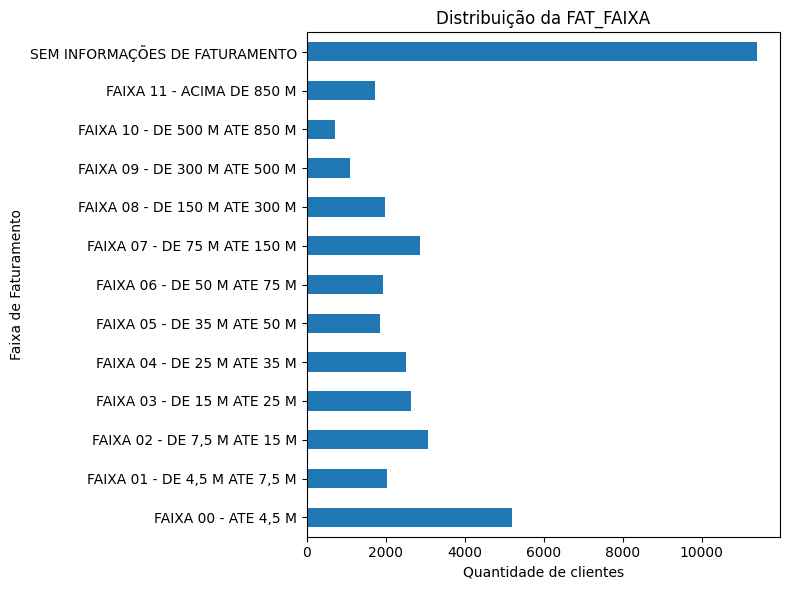

In [4]:
# Voltando para a base original, vamos estudar a coluna de faturamento de clientes para agrupa-la da melhor forma

import matplotlib.pyplot as plt

# Contagem absoluta
print(df["FAT_FAIXA"].value_counts())

# Contagem relativa (percentual)
print("\nDistribuição percentual:")
print(df["FAT_FAIXA"].value_counts(normalize=True).round(3) * 100)

# Gráfico de barras
df["FAT_FAIXA"].value_counts().sort_index().plot(
    kind="barh", figsize=(8,6), title="Distribuição da FAT_FAIXA"
)
plt.xlabel("Quantidade de clientes")
plt.ylabel("Faixa de Faturamento")
plt.tight_layout()
plt.show()


In [5]:
# A partir da analise da distribuição dos clientes por faixas de receita, escolhemos reagrupar dessa forma abaixo
# Criar mapeamento manual das faixas
mapa_fat_faixa = {
    "SEM INFORMACOES DE FATURAMENTO": "SEM_INFO",
    "FAIXA 00 - ATE 4,5 M": "ATE 15M",
    "FAIXA 01 - DE 4,5 M ATE 7,5 M": "ATE 15M",
    "FAIXA 02 - DE 7,5 M ATE 15 M": "ATE 15M",
    "FAIXA 03 - DE 15 M ATE 25 M": "15M-50M",
    "FAIXA 04 - DE 25 M ATE 35 M": "15M-50M",
    "FAIXA 05 - DE 35 M ATE 50 M": "15M-50M",
    "FAIXA 06 - DE 50 M ATE 75 M": "50M-150M",
    "FAIXA 07 - DE 75 M ATE 150 M": "50M-150M",
    "FAIXA 08 - DE 150 M ATE 300 M": "ACIMA 150M",
    "FAIXA 09 - DE 300 M ATE 500 M": "ACIMA 150M",
    "FAIXA 10 - DE 500 M ATE 850 M": "ACIMA 150M",
    "FAIXA 11 - ACIMA DE 850 M": "ACIMA 150M"
}

# Padronizar e mapear
df["FAT_FAIXA"] = df["FAT_FAIXA"].str.upper().str.strip()
df["FAT_FAIXA_AGRUPADA"] = df["FAT_FAIXA"].map(mapa_fat_faixa).fillna("SEM_INFO")
df["FAT_FAIXA_AGRUPADA"] = df["FAT_FAIXA_AGRUPADA"].astype("category")

# Conferência
print(df["FAT_FAIXA_AGRUPADA"].value_counts())


FAT_FAIXA_AGRUPADA
SEM_INFO      11407
ATE 15M       10286
15M-50M        7020
ACIMA 150M     5557
50M-150M       4786
Name: count, dtype: int64


In [6]:
df.head()

,CD_CLIENTE,DS_LIN_REC,DS_SEGMENTO,FAT_FAIXA,CONTRATO_ATIVO,CONTRATO_CANCELADO,CONTRATO_GRATUITO,CONTRATO_OUTROS,FAIXA_VL_CONTRATO_FIXA,FAT_FAIXA_AGRUPADA
0,99958,SMS,SERVICOS,FAIXA 09 - DE 300 M ATE 500 M,0,0,1,0,>R$1M,ACIMA 150M
1,99958,CDU,SERVICOS,FAIXA 09 - DE 300 M ATE 500 M,0,0,1,0,>R$1M,ACIMA 150M
2,99069,SAAS,VAREJO,SEM INFORMAÇÕES DE FATURAMENTO,0,0,1,0,R$5k–20k,SEM_INFO
3,T00082,SAAS,CONSTRUCAO E PROJETOS,FAIXA 04 - DE 25 M ATE 35 M,1,0,0,0,R$100k–500k,15M-50M
4,T00018,SMS,SERVICOS,"FAIXA 02 - DE 7,5 M ATE 15 M",1,0,0,0,até R$5k,ATE 15M


In [7]:
# Agrupar por cliente + linha de receita
df_agrupado = (
    df.groupby(["CD_CLIENTE", "DS_LIN_REC"], as_index=False)
      .agg({
          "DS_SEGMENTO": "first",           # mantém o segmento associado
          "FAT_FAIXA_AGRUPADA": "first",    # mantém a faixa de faturamento original
          "FAIXA_VL_CONTRATO_FIXA": "first",# mantém a faixa de faturamento original
          "CONTRATO_ATIVO": "max",          # 1 se já teve contrato ativo
          "CONTRATO_CANCELADO": "max",      # 1 se já teve contrato cancelado
          "CONTRATO_GRATUITO": "max",       # 1 se já teve contrato gratuito
          "CONTRATO_OUTROS": "max"          # 1 se já teve contrato em outros status
      })
)

print(df_agrupado.head())
print(df_agrupado.shape)

  CD_CLIENTE DS_LIN_REC DS_SEGMENTO FAT_FAIXA_AGRUPADA FAIXA_VL_CONTRATO_FIXA  \
0      99069       SAAS      VAREJO           SEM_INFO               R$5k–20k   
1      99958        CDU    SERVICOS         ACIMA 150M                  >R$1M   
2      99958       SAAS    SERVICOS         ACIMA 150M                  >R$1M   
3      99958        SMS    SERVICOS         ACIMA 150M                  >R$1M   
4      99999        CDU       TOTVS           SEM_INFO               até R$5k   

   CONTRATO_ATIVO  CONTRATO_CANCELADO  CONTRATO_GRATUITO  CONTRATO_OUTROS  
0               0                   0                  1                0  
1               0                   0                  1                0  
2               0                   0                  1                0  
3               0                   0                  1                0  
4               0                   1                  1                0  
(10815, 9)


In [8]:
import pandas as pd

### Integração com a base clientes_desde.csv
# Caminho do arquivo
caminho_desde = r'C:/Users/anabe/Documents/FIAP/Ano 2/0. Challenge/Challenge_TOTVS_2025_MassaDados_v1/clientes_desde.csv'

# Leitura correta com tratamento de BOM e separador
df_desde = pd.read_csv(caminho_desde, sep=';', encoding='utf-8-sig')

# Converter a coluna de datas
df_desde['CLIENTE_DESDE'] = pd.to_datetime(df_desde['CLIENTE_DESDE'], errors='coerce')

df_desde.rename(columns={'CLIENTE': 'CD_CLIENTE'}, inplace=True)


📊 Estatísticas de CLIENTE_DESDE
Mínimo : 1971-04-19 00:00:00
Máximo : 2025-03-24 00:00:00
Mediana: 2018-09-20 00:00:00
Quartis:
0.25   2012-02-17
0.50   2018-09-20
0.75   2022-09-09
Name: CLIENTE_DESDE, dtype: datetime64[ns]

📌 Distribuição de clientes por ano:
ANO_INICIO
1971       1
1988       4
1989       5
1990      10
1991      19
1992      13
1993      12
1994      28
1995      25
1996      32
1997      42
1998      40
1999      58
2000      71
2001      72
2002      89
2003      71
2004      91
2005     106
2006     158
2007     202
2008     173
2009     330
2010     551
2011     417
2012     413
2013     468
2014     430
2015     349
2016     369
2017     345
2018     456
2019     430
2020     548
2021     836
2022     989
2023     951
2024    1164
2025     247
Name: count, dtype: int64


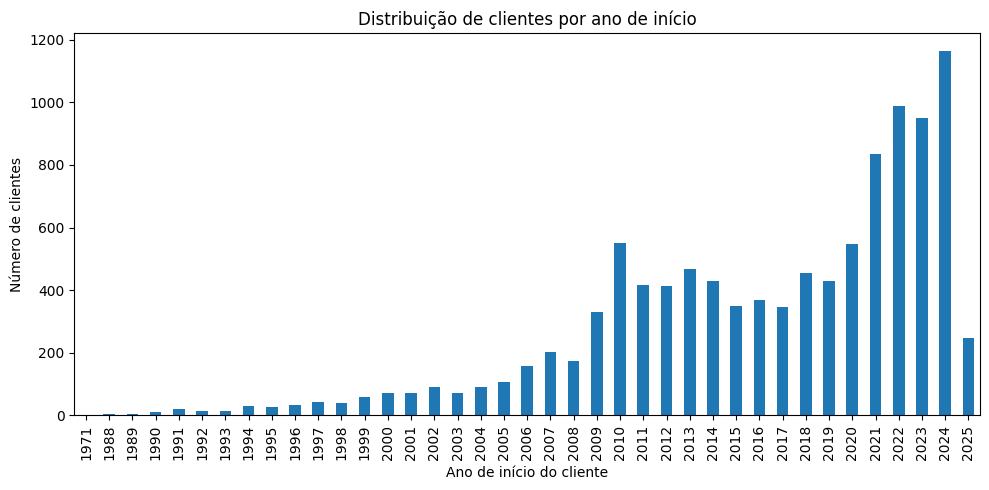


📊 Estatísticas de tempo de relacionamento (anos):
count    10615.000000
mean         8.294112
std          7.050304
min          0.000000
25%          2.000000
50%          6.000000
75%         13.000000
max         54.000000
Name: TEMPO_CLIENTE_ANOS, dtype: float64


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Estudo da base para melhor agrupamento
# Estatísticas básicas das datas
print("📊 Estatísticas de CLIENTE_DESDE")
print("Mínimo :", df_desde["CLIENTE_DESDE"].min())
print("Máximo :", df_desde["CLIENTE_DESDE"].max())
print("Mediana:", df_desde["CLIENTE_DESDE"].median())
print("Quartis:")
print(df_desde["CLIENTE_DESDE"].quantile([0.25, 0.5, 0.75]))

# 2. Distribuição por ano
df_desde["ANO_INICIO"] = df_desde["CLIENTE_DESDE"].dt.year
print("\n📌 Distribuição de clientes por ano:")
print(df_desde["ANO_INICIO"].value_counts().sort_index())

# 3. Gráfico da distribuição por ano
df_desde["ANO_INICIO"].value_counts().sort_index().plot(
    kind="bar", figsize=(10,5), title="Distribuição de clientes por ano de início"
)
plt.xlabel("Ano de início do cliente")
plt.ylabel("Número de clientes")
plt.tight_layout()
plt.show()

# 4. Tempo de relacionamento em anos
hoje = pd.to_datetime("today")
df_desde["TEMPO_CLIENTE_ANOS"] = (
    (hoje - df_desde["CLIENTE_DESDE"]).dt.days // 365
)

print("\n📊 Estatísticas de tempo de relacionamento (anos):")
print(df_desde["TEMPO_CLIENTE_ANOS"].describe())


In [10]:
# Vamos agrupar os tempos de relacionamento dos clientes conforme as faixas "Recente (0-3 anos)", "Estabelecido (3-10 anos)", "Madura (>10 anos)"

bins = [0, 3, 10, np.inf]
labels = ["Recente (0-3)", "Estabelecido (3-10)", "Madura (>10)"]

df_desde["TEMPO_CLIENTE_FAIXA"] = pd.cut(
    df_desde["TEMPO_CLIENTE_ANOS"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
).astype("category")

# --- 3) Distribuição (contagem e %) ---
dist_abs = df_desde["TEMPO_CLIENTE_FAIXA"].value_counts().reindex(labels)
dist_pct = (df_desde["TEMPO_CLIENTE_FAIXA"].value_counts(normalize=True) * 100).round(2).reindex(labels)

print("📊 Distribuição por faixa (absoluto):")
print(dist_abs)
print("\n📊 Distribuição por faixa (%):")
print(dist_pct)

📊 Distribuição por faixa (absoluto):
TEMPO_CLIENTE_FAIXA
Recente (0-3)          3666
Estabelecido (3-10)    3176
Madura (>10)           3773
Name: count, dtype: int64

📊 Distribuição por faixa (%):
TEMPO_CLIENTE_FAIXA
Recente (0-3)          34.54
Estabelecido (3-10)    29.92
Madura (>10)           35.54
Name: proportion, dtype: float64


In [11]:
df_merged = pd.merge(
    df_agrupado, 
    df_desde, 
    on="CD_CLIENTE",     # chave de junção
    how="left"           # mantém todos os clientes do df_agrupado
)

df_merged.head()

,CD_CLIENTE,DS_LIN_REC,DS_SEGMENTO,FAT_FAIXA_AGRUPADA,FAIXA_VL_CONTRATO_FIXA,CONTRATO_ATIVO,CONTRATO_CANCELADO,CONTRATO_GRATUITO,CONTRATO_OUTROS,CLIENTE_DESDE,ANO_INICIO,TEMPO_CLIENTE_ANOS,TEMPO_CLIENTE_FAIXA
0,99069,SAAS,VAREJO,SEM_INFO,R$5k–20k,0,0,1,0,2017-08-31,2017,8,Estabelecido (3-10)
1,99958,CDU,SERVICOS,ACIMA 150M,>R$1M,0,0,1,0,2016-04-07,2016,9,Estabelecido (3-10)
2,99958,SAAS,SERVICOS,ACIMA 150M,>R$1M,0,0,1,0,2016-04-07,2016,9,Estabelecido (3-10)
3,99958,SMS,SERVICOS,ACIMA 150M,>R$1M,0,0,1,0,2016-04-07,2016,9,Estabelecido (3-10)
4,99999,CDU,TOTVS,SEM_INFO,até R$5k,0,1,1,0,2006-06-16,2006,19,Madura (>10)


In [12]:
# Excluir a coluna original
df_merged.drop(columns=["CLIENTE_DESDE","ANO_INICIO","TEMPO_CLIENTE_ANOS"], inplace=True)


In [13]:
# chegamos na base final, ante do hot encoding

print(df_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10815 entries, 0 to 10814
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   CD_CLIENTE              10815 non-null  object  
 1   DS_LIN_REC              10815 non-null  object  
 2   DS_SEGMENTO             10815 non-null  object  
 3   FAT_FAIXA_AGRUPADA      10815 non-null  category
 4   FAIXA_VL_CONTRATO_FIXA  10815 non-null  category
 5   CONTRATO_ATIVO          10815 non-null  int64   
 6   CONTRATO_CANCELADO      10815 non-null  int64   
 7   CONTRATO_GRATUITO       10815 non-null  int64   
 8   CONTRATO_OUTROS         10815 non-null  int64   
 9   TEMPO_CLIENTE_FAIXA     10815 non-null  category
dtypes: category(3), int64(4), object(3)
memory usage: 624.0+ KB
None


### One Hot Encoding e últimos tratamentos
#### Vamos transformar variáveis categóricas em representações numéricas binárias para usa-las no algoritmo de clustering

In [14]:
import pandas as pd

# Defina as colunas categóricas que deseja transformar em dummies
cols_categoricas = [
    "DS_LIN_REC", "DS_SEGMENTO", "FAT_FAIXA_AGRUPADA",
    "FAIXA_VL_CONTRATO_FIXA", "TEMPO_CLIENTE_FAIXA"
]

# 2. Gerar variáveis dummies
df_dummies = pd.get_dummies(df_merged[cols_categoricas], prefix=cols_categoricas)

# 3. Selecionar colunas binárias CONTRATO_*
col_contratos = [col for col in df_merged.columns if col.startswith("CONTRATO_")]

# 4. Juntar tudo (ID cliente, colunas CONTRATO_*, e dummies)
df_cluster_base = pd.concat(
    [df_merged[["CD_CLIENTE"] + col_contratos], df_dummies],
    axis=1
)

# 5. Agrupar por cliente, somando ocorrências
df_cluster_final = df_cluster_base.groupby("CD_CLIENTE").sum().reset_index()

# ✅ df_cluster_final pronto para clusterização (K-Means, HDBSCAN, etc.)
print(df_cluster_final.shape)
df_cluster_final.head()


(5641, 41)


,CD_CLIENTE,CONTRATO_ATIVO,CONTRATO_CANCELADO,CONTRATO_GRATUITO,CONTRATO_OUTROS,DS_LIN_REC_CDU,DS_LIN_REC_CLOUD,DS_LIN_REC_CONSULTORIA & SERVIÇOS,DS_LIN_REC_OUTROS,DS_LIN_REC_SAAS,...,FAIXA_VL_CONTRATO_FIXA_Zero,FAIXA_VL_CONTRATO_FIXA_até R$5k,FAIXA_VL_CONTRATO_FIXA_R$5k–20k,FAIXA_VL_CONTRATO_FIXA_R$20k–100k,FAIXA_VL_CONTRATO_FIXA_R$100k–500k,FAIXA_VL_CONTRATO_FIXA_R$500k–1M,FAIXA_VL_CONTRATO_FIXA_>R$1M,TEMPO_CLIENTE_FAIXA_Recente (0-3),TEMPO_CLIENTE_FAIXA_Estabelecido (3-10),TEMPO_CLIENTE_FAIXA_Madura (>10)
0,99069,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
1,99958,0,0,3,0,1,0,0,0,1,...,0,0,0,0,0,0,3,0,3,0
2,99999,0,2,2,0,1,0,0,0,0,...,0,2,0,0,0,0,0,0,0,2
3,T00018,1,0,2,0,1,0,0,0,0,...,0,2,0,0,0,0,0,0,0,2
4,T00053,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [15]:
import numpy as np

# garantir 0/1 inteiros nas flags
cols_flags = ["CONTRATO_ATIVO","CONTRATO_CANCELADO","CONTRATO_GRATUITO","CONTRATO_OUTROS"]
df_cluster_final[cols_flags] = df_cluster_final[cols_flags].fillna(0).astype(int)

# inativo = (≥1 cancelado) E (nenhum outro status marcado)
tem_cancelado = df_cluster_final["CONTRATO_CANCELADO"] >= 1
tem_outros    = df_cluster_final[["CONTRATO_ATIVO","CONTRATO_GRATUITO","CONTRATO_OUTROS"]].sum(axis=1) >= 1

df_cluster_final["CLIENTE_INATIVO"] = (tem_cancelado & ~tem_outros).astype("int8")

# ativo = complemento do inativo (1 para ativo, 0 para inativo)
df_cluster_final["CLIENTE_ATIVO"] = (1 - df_cluster_final["CLIENTE_INATIVO"]).astype("int8")

# checagem rápida
print(df_cluster_final[["CONTRATO_ATIVO","CONTRATO_CANCELADO","CONTRATO_GRATUITO","CONTRATO_OUTROS",
                 "CLIENTE_INATIVO","CLIENTE_ATIVO"]].head())
print("Ativos:", int(df_cluster_final["CLIENTE_ATIVO"].sum()),
      "| Inativos:", int(df_cluster_final["CLIENTE_INATIVO"].sum()))

# Excluir a coluna original
df_cluster_final.drop(columns=["CONTRATO_ATIVO","CONTRATO_CANCELADO","CONTRATO_OUTROS","CLIENTE_INATIVO","CONTRATO_GRATUITO"], inplace=True)



   CONTRATO_ATIVO  CONTRATO_CANCELADO  CONTRATO_GRATUITO  CONTRATO_OUTROS  \
0               0                   0                  1                0   
1               0                   0                  3                0   
2               0                   2                  2                0   
3               1                   0                  2                0   
4               1                   0                  0                0   

   CLIENTE_INATIVO  CLIENTE_ATIVO  
0                0              1  
1                0              1  
2                0              1  
3                0              1  
4                0              1  
Ativos: 5340 | Inativos: 301


In [16]:
# Copiar o DataFrame original para evitar sobrescrever sem querer
df_bin = df_cluster_final.copy()

# Identificar todas as colunas, exceto 'CD_CLIENTE'
cols_para_binarizar = df_bin.columns.difference(['CD_CLIENTE'])

# Aplicar a transformação: se valor > 0, vira 1; senão, 0
df_bin[cols_para_binarizar] = (df_bin[cols_para_binarizar] > 0).astype(int)

# Conferir
print(df_bin.head())


  CD_CLIENTE  DS_LIN_REC_CDU  DS_LIN_REC_CLOUD  \
0      99069               0                 0   
1      99958               1                 0   
2      99999               1                 0   
3     T00018               1                 0   
4     T00053               0                 0   

   DS_LIN_REC_CONSULTORIA & SERVIÇOS  DS_LIN_REC_OUTROS  DS_LIN_REC_SAAS  \
0                                  0                  0                1   
1                                  0                  0                1   
2                                  0                  0                0   
3                                  0                  0                0   
4                                  0                  1                0   

   DS_LIN_REC_SMS  DS_SEGMENTO_AGROINDUSTRIA  \
0               0                          0   
1               1                          0   
2               1                          0   
3               1                          0   
4 

In [17]:
# supondo df_bin já montado
# garanta 0/1 como int8 para economizar memória/IO
bin_cols = [c for c in df_bin.columns if c != "CD_CLIENTE"]
df_bin[bin_cols] = df_bin[bin_cols].astype("int8")
df_bin["CD_CLIENTE"] = df_bin["CD_CLIENTE"].astype("string")

df_bin.to_csv("df_bin.csv",
    index=False,
    encoding="utf-8",   # evite utf-8-sig (BOM) — pode atrapalhar em alguns parsers
)


### Modelo de Clusterização

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [19]:
# Separar a coluna de ID antes do modelo
ids_clientes = df_bin["CD_CLIENTE"]

# Remover coluna de identificação (não usada no KMeans)
df_numerico = df_bin.drop(columns=["CD_CLIENTE"])


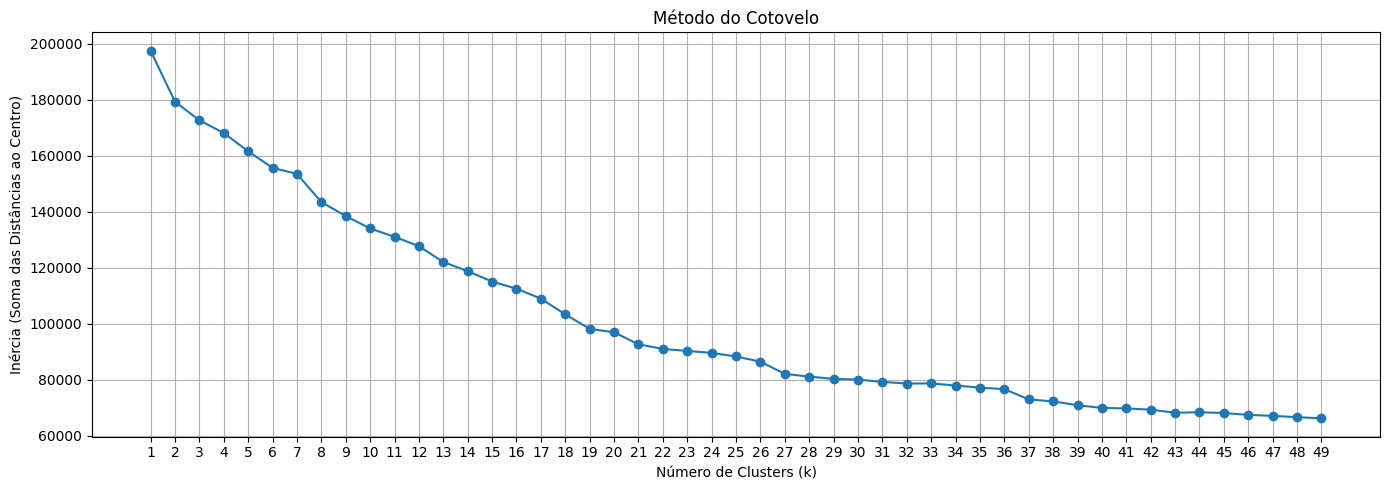

In [20]:
# Técnica do cotovelo para definir número de clusters
# Normalizar os dados (importante para o KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numerico)

# Testar diferentes valores de K
inertia = []
k_range = range(1, 50)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotar o gráfico do cotovelo
plt.figure(figsize=(14, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (Soma das Distâncias ao Centro)')
plt.grid(True)
plt.xticks(k_range)
plt.tight_layout()
plt.show()



In [30]:
# Analisando o gráfico de cotovelo, entendemos que poderíamos ter 19, 22 ou 27 clusters. Escolhemos 19, por ser o menor número e facilitar a análise posterior.
# Vale comentar que o gráfico não está tão marcante, mas para efeito do exercício vamos seguir assim e posteriormente na solução final faremos novos tratamentos das bases
# e entendemos se podemos chegar num resultado melhor

import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Treinar KMeans com K=19
K = 19
kmeans = KMeans(n_clusters=K, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_scaled)

# Métricas de validade
sil = silhouette_score(X_scaled, labels)
db  = davies_bouldin_score(X_scaled, labels)
ch  = calinski_harabasz_score(X_scaled, labels)
print(f"K={K} | Silhouette={sil:.4f} | Davies-Bouldin={db:.4f} | Calinski-Harabasz={ch:.2f}")

# Rótulos por cliente + tamanhos
df_clusters = df_bin[[id_col]].copy()
df_clusters["cluster"] = labels

sizes = df_clusters["cluster"].value_counts().sort_index().to_frame("n")
sizes["pct"] = (sizes["n"] / len(df_clusters)).round(4)
print("\nTamanho dos clusters:")
print(sizes)

# “Centroides” como prevalência (média das dummies no cluster)
centroids = (df_bin.assign(cluster=labels)
             .groupby("cluster")[feature_cols]
             .mean().round(3))


K=19 | Silhouette=0.1552 | Davies-Bouldin=1.5230 | Calinski-Harabasz=326.28

Tamanho dos clusters:
           n     pct
cluster             
0        461  0.0817
1        162  0.0287
2        624  0.1106
3        326  0.0578
4        490  0.0869
5        484  0.0858
6        557  0.0987
7         63  0.0112
8        745  0.1321
9        306  0.0542
10       349  0.0619
11         2  0.0004
12         5  0.0009
13       154  0.0273
14        75  0.0133
15         2  0.0004
16       393  0.0697
17       334  0.0592
18       109  0.0193


#### Analisando a qualidade do modelo de clusterização com K igual a 19, vemos que o Silhouette Score tem valor 0,1552, considerado baixo, o que indica que os clusters formados não são tão bem definidas e que há sobreposição entre alguns grupos. O Davies-Bouldin Index, que mede a proximidade entre clusters, ficou em 1,5230, valor relativamente alto para esse tipo de métrica, sugerindo que os grupos formados ainda estão próximos entre si e não apresentam grande separação. Já o Calinski-Harabasz Index, que avalia a relação entre a dispersão interna e externa dos clusters, obteve o valor de 326,28, que não é particularmente elevado, reforçando a interpretação de que a segmentação poderia ser mais consistente. De forma geral, os resultados mostram que o modelo conseguiu organizar os clientes em grupos diferentes, mas a qualidade da clusterização ainda é limitada. Para a solução final, vamos revisar as variáveis, tentar técnicas de padronização ou testar outros algoritmos para alcançar resultados mais robustos.

In [34]:
# <<< AQUI: define a lista de clusters >>>
clusters = np.sort(np.unique(labels))

In [ ]:
import pandas as pd
import numpy as np

# Agora vamos ver quais características prevalecem em cada cluster , trazendo a analise de feature importance junto

id_col = "CD_CLIENTE"
feature_cols = [c for c in df_bin.columns if c != id_col]

# Prevalência global (média de cada dummy na base toda)
global_prev = df_bin[feature_cols].mean()

def perfil_com_lift(centroids, cluster_id, top=5, min_base=0.01):
    """
    Retorna os principais sinais de um cluster,
    com métricas de prevalência, lift e delta absoluto.
    """
    prof = centroids.loc[cluster_id].copy()
    base = global_prev.copy()

    # evitar divisão por zero (se alguma feature nunca aparece globalmente)
    base = base.replace({0: np.nan})
    lift = prof / base
    delta = (prof - global_prev)

    out = pd.DataFrame({
        "prevalencia": prof,
        "prev_global": global_prev,
        "lift": lift,
        "delta_abs": delta
    })

    # filtrar para manter apenas sinais com presença mínima na base
    out = out[global_prev >= min_base].sort_values(
        ["lift", "delta_abs"], ascending=False
    )
    return out.head(top).round(3)

# Iterar sobre todos os clusters e mostrar os top sinais
TOP = 5
for c in centroids.index:
    print(f"\n🔎 Cluster {c} — top {TOP} sinais")
    display(perfil_com_lift(centroids, c, top=TOP))



🔎 Cluster 0 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
DS_SEGMENTO_DISTRIBUICAO,1.000,0.099,10.109,0.901
FAT_FAIXA_AGRUPADA_ATE 15M,0.560,0.292,1.918,0.268
DS_LIN_REC_SMS,0.733,0.386,1.900,0.347
FAIXA_VL_CONTRATO_FIXA_R$5k–20k,0.328,0.187,1.752,0.141
DS_LIN_REC_CONSULTORIA & SERVIÇOS,0.150,0.088,1.706,0.062



🔎 Cluster 1 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
DS_LIN_REC_CONSULTORIA & SERVIÇOS,1.000,0.088,11.373,0.912
DS_SEGMENTO_VAREJO,0.420,0.199,2.112,0.221
TEMPO_CLIENTE_FAIXA_Recente (0-3),0.500,0.252,1.988,0.248
DS_SEGMENTO_EDUCACIONAL,0.093,0.050,1.847,0.043
DS_SEGMENTO_SERVICOS,0.340,0.197,1.722,0.143



🔎 Cluster 2 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
TEMPO_CLIENTE_FAIXA_Estabelecido (3-10),0.931,0.339,2.742,0.592
FAIXA_VL_CONTRATO_FIXA_até R$5k,0.947,0.362,2.616,0.585
DS_SEGMENTO_VAREJO,0.441,0.199,2.217,0.242
DS_SEGMENTO_SERVICOS,0.397,0.197,2.010,0.200
FAT_FAIXA_AGRUPADA_SEM_INFO,0.636,0.376,1.693,0.260



🔎 Cluster 3 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
DS_SEGMENTO_LOGISTICA,1.000,0.061,16.446,0.939
DS_LIN_REC_CLOUD,0.245,0.175,1.399,0.070
FAIXA_VL_CONTRATO_FIXA_R$100k–500k,0.202,0.151,1.341,0.051
FAT_FAIXA_AGRUPADA_15M-50M,0.175,0.145,1.205,0.030
DS_LIN_REC_SMS,0.457,0.386,1.185,0.071



🔎 Cluster 4 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
FAIXA_VL_CONTRATO_FIXA_R$5k–20k,1.000,0.187,5.342,0.813
DS_LIN_REC_CLOUD,0.384,0.175,2.192,0.209
DS_SEGMENTO_VAREJO,0.410,0.199,2.061,0.211
FAT_FAIXA_AGRUPADA_ATE 15M,0.512,0.292,1.754,0.220
DS_SEGMENTO_MANUFATURA,0.312,0.214,1.458,0.098



🔎 Cluster 5 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
FAT_FAIXA_AGRUPADA_15M-50M,1.000,0.145,6.888,0.855
DS_SEGMENTO_MANUFATURA,0.523,0.214,2.444,0.309
FAIXA_VL_CONTRATO_FIXA_R$20k–100k,0.581,0.273,2.131,0.308
TEMPO_CLIENTE_FAIXA_Madura (>10),0.773,0.409,1.890,0.364
FAIXA_VL_CONTRATO_FIXA_R$100k–500k,0.273,0.151,1.812,0.122



🔎 Cluster 6 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
FAT_FAIXA_AGRUPADA_ATE 15M,0.831,0.292,2.846,0.539
FAIXA_VL_CONTRATO_FIXA_R$20k–100k,0.686,0.273,2.516,0.413
DS_SEGMENTO_MANUFATURA,0.442,0.214,2.066,0.228
DS_LIN_REC_SMS,0.652,0.386,1.690,0.266
DS_SEGMENTO_VAREJO,0.336,0.199,1.689,0.137



🔎 Cluster 7 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
FAIXA_VL_CONTRATO_FIXA_>R$1M,1.000,0.011,89.540,0.989
FAT_FAIXA_AGRUPADA_ACIMA 150M,0.651,0.090,7.272,0.561
DS_SEGMENTO_AGROINDUSTRIA,0.143,0.021,6.836,0.122
DS_LIN_REC_OUTROS,0.635,0.116,5.486,0.519
DS_LIN_REC_CONSULTORIA & SERVIÇOS,0.238,0.088,2.707,0.150



🔎 Cluster 8 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
TEMPO_CLIENTE_FAIXA_Recente (0-3),0.976,0.252,3.880,0.724
FAT_FAIXA_AGRUPADA_SEM_INFO,0.981,0.376,2.612,0.605
FAIXA_VL_CONTRATO_FIXA_até R$5k,0.938,0.362,2.591,0.576
DS_SEGMENTO_SERVICOS,0.482,0.197,2.441,0.285
DS_SEGMENTO_EDUCACIONAL,0.083,0.050,1.649,0.033



🔎 Cluster 9 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
DS_SEGMENTO_CONSTRUCAO E PROJETOS,1.000,0.056,17.739,0.944
DS_LIN_REC_CLOUD,0.245,0.175,1.399,0.070
FAT_FAIXA_AGRUPADA_50M-150M,0.134,0.098,1.364,0.036
FAT_FAIXA_AGRUPADA_15M-50M,0.193,0.145,1.329,0.048
TEMPO_CLIENTE_FAIXA_Recente (0-3),0.320,0.252,1.272,0.068



🔎 Cluster 10 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
FAT_FAIXA_AGRUPADA_ACIMA 150M,0.997,0.090,11.137,0.907
FAIXA_VL_CONTRATO_FIXA_R$500k–1M,0.143,0.016,8.768,0.127
FAIXA_VL_CONTRATO_FIXA_R$100k–500k,0.564,0.151,3.743,0.413
DS_LIN_REC_OUTROS,0.284,0.116,2.453,0.168
DS_SEGMENTO_MANUFATURA,0.464,0.214,2.169,0.250



🔎 Cluster 11 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
FAT_FAIXA_AGRUPADA_ATE 15M,1.0,0.292,3.425,0.708
FAIXA_VL_CONTRATO_FIXA_R$100k–500k,0.5,0.151,3.318,0.349
DS_LIN_REC_CLOUD,0.5,0.175,2.855,0.325
FAIXA_VL_CONTRATO_FIXA_R$5k–20k,0.5,0.187,2.671,0.313
TEMPO_CLIENTE_FAIXA_Estabelecido (3-10),0.5,0.339,1.473,0.161



🔎 Cluster 12 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
FAT_FAIXA_AGRUPADA_SEM_INFO,1.0,0.376,2.662,0.624
TEMPO_CLIENTE_FAIXA_Estabelecido (3-10),0.8,0.339,2.357,0.461
FAIXA_VL_CONTRATO_FIXA_até R$5k,0.8,0.362,2.210,0.438
DS_LIN_REC_SAAS,0.8,0.609,1.314,0.191
DS_LIN_REC_CLOUD,0.2,0.175,1.142,0.025



🔎 Cluster 13 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
DS_SEGMENTO_SAUDE,1.000,0.028,35.930,0.972
FAIXA_VL_CONTRATO_FIXA_R$500k–1M,0.045,0.016,2.759,0.029
FAT_FAIXA_AGRUPADA_50M-150M,0.156,0.098,1.588,0.058
FAIXA_VL_CONTRATO_FIXA_R$100k–500k,0.208,0.151,1.380,0.057
FAT_FAIXA_AGRUPADA_ACIMA 150M,0.117,0.090,1.307,0.027



🔎 Cluster 14 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
DS_SEGMENTO_JURIDICO,1.000,0.013,75.213,0.987
FAT_FAIXA_AGRUPADA_ATE 15M,0.573,0.292,1.963,0.281
DS_LIN_REC_CONSULTORIA & SERVIÇOS,0.147,0.088,1.672,0.059
FAIXA_VL_CONTRATO_FIXA_R$20k–100k,0.427,0.273,1.566,0.154
DS_LIN_REC_CDU,0.720,0.544,1.324,0.176



🔎 Cluster 15 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
FAIXA_VL_CONTRATO_FIXA_R$5k–20k,0.5,0.187,2.671,0.313
FAT_FAIXA_AGRUPADA_SEM_INFO,1.0,0.376,2.662,0.624
DS_LIN_REC_CDU,1.0,0.544,1.839,0.456
TEMPO_CLIENTE_FAIXA_Estabelecido (3-10),0.5,0.339,1.473,0.161
FAIXA_VL_CONTRATO_FIXA_até R$5k,0.5,0.362,1.381,0.138



🔎 Cluster 16 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
FAT_FAIXA_AGRUPADA_50M-150M,1.000,0.098,10.182,0.902
FAIXA_VL_CONTRATO_FIXA_R$100k–500k,0.415,0.151,2.754,0.264
DS_SEGMENTO_MANUFATURA,0.550,0.214,2.570,0.336
FAIXA_VL_CONTRATO_FIXA_R$500k–1M,0.041,0.016,2.514,0.025
TEMPO_CLIENTE_FAIXA_Madura (>10),0.768,0.409,1.878,0.359



🔎 Cluster 17 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
DS_SEGMENTO_HOSPITALITY,1.000,0.060,16.789,0.940
DS_LIN_REC_CONSULTORIA & SERVIÇOS,0.210,0.088,2.388,0.122
FAIXA_VL_CONTRATO_FIXA_até R$5k,0.662,0.362,1.829,0.300
FAT_FAIXA_AGRUPADA_SEM_INFO,0.602,0.376,1.603,0.226
DS_LIN_REC_SAAS,0.850,0.609,1.396,0.241



🔎 Cluster 18 — top 5 sinais


,prevalencia,prev_global,lift,delta_abs
DS_SEGMENTO_AGROINDUSTRIA,1.000,0.021,47.805,0.979
FAT_FAIXA_AGRUPADA_ACIMA 150M,0.266,0.090,2.971,0.176
FAIXA_VL_CONTRATO_FIXA_R$500k–1M,0.037,0.016,2.269,0.021
FAIXA_VL_CONTRATO_FIXA_R$100k–500k,0.275,0.151,1.825,0.124
FAT_FAIXA_AGRUPADA_50M-150M,0.156,0.098,1.588,0.058


##### Escolhemos dois cluster com mais quantidade de clientes para entender alguns comportamentos e perfis:
##### No caso do Cluster 3, observa-se uma forte concentração de clientes com tempo de relacionamento estabelecido entre 3 e 10 anos (93,1%), o que representa um perfil maduro em comparação à média global (33,9%). Além disso, há grande prevalência de contratos de baixo valor, até R$5 mil (94,7%), indicando uma base significativa de clientes de menor ticket médio, mas com alta fidelização. Esse grupo também apresenta representatividade elevada nos segmentos de Varejo (44,1%) e Serviços (39,7%), além de uma presença relevante em clientes sem informações de faixa de faturamento (63,6%). Em síntese, o Cluster 3 caracteriza-se por clientes estabelecidos, de longa duração, mas com contratos de baixo valor, predominantemente em Varejo e Serviços.

##### Já o Cluster 6 reúne clientes majoritariamente da faixa de faturamento até R$15 milhões (83,1%) e com contratos na faixa de R$20 mil a R$100 mil (68,6%), o que representa um perfil intermediário de ticket médio. O grupo apresenta forte ligação com o segmento de Manufatura (44,2%), além de elevada incidência de linha de receita SMS (65,2%), e ainda mantém participação significativa no segmento de Varejo (33,6%). Dessa forma, o Cluster 6 concentra empresas de médio porte e faturamento, vinculadas a soluções de comunicação e serviços industriais, apresentando-se como um segmento distinto e potencialmente estratégico dentro da base analisada.

#### Resultado Visual do K-Means

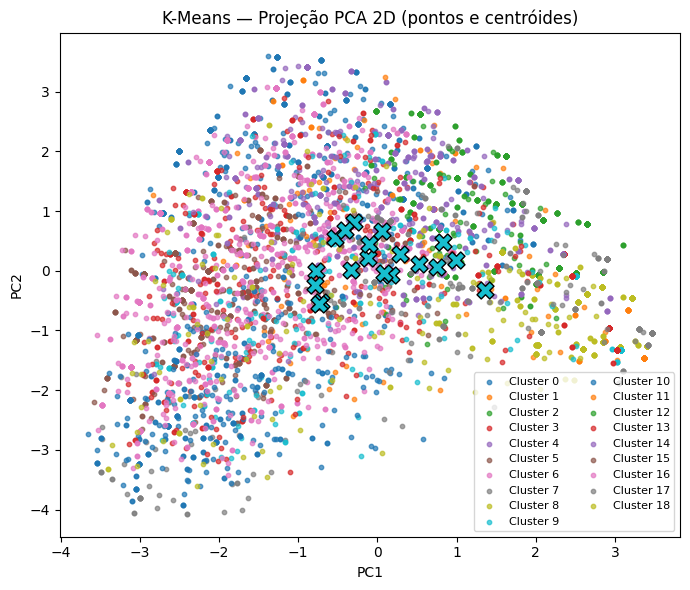

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

# PCA 2D: scatter com centróides projetados

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_scaled)

# projetar centróides (que estão no espaço das features) no mesmo PCA
# para isso, precisamos garantir que a mesma transformação se aplique.
# Se X_scaled já está padronizado, projetamos centroids "no mesmo espaço de X_scaled":
centroids_matrix = centroids[feature_cols].values  # medias por cluster (no espaço original das features 0/1)
# se você escalou X antes de KMeans, projete centróides na mesma escala:
# Caso tenha usado StandardScaler, recompute com o mesmo scaler. Aqui assumimos X_scaled já corresponde.
Zc = pca.transform(centroids_matrix)

plt.figure(figsize=(7, 6))
for c in clusters:
    plt.scatter(Z[labels==c, 0], Z[labels==c, 1], s=10, alpha=0.7, label=f"Cluster {c}")
plt.scatter(Zc[:, 0], Zc[:, 1], s=150, marker="X", edgecolor="black", linewidths=1)
plt.title("K-Means — Projeção PCA 2D (pontos e centróides)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()


#### Mais uma vez, fica demonstrada a baixa qualidade técnica do modelo, já que os clusters aparecem muito misturados e dispersos. Ainda assim, pudemos entender o potencial desse tipo de análise para representar comportamentos e perfis comuns e endereçar futuras soluções de negócio e análises adicionais, como NPS, jornada de relacionamento e pontos de contato. Para a solução final vamos retrabalhar as bases, variáveis e categorizações para chegarmos em clusters mais consistentes